# 用 Flickr8k 数据集实现简单的图像标注

## 1 图像标注（image captioning）介绍

  图像标注是近几年来深度学习中很火的领域，它涉及了计算机视觉（CV）和自然语言处理（NLP）两个领域的结合。简单来说，根据一张图片的信息生成对应的文字描述。

<img src="images/image captioning.jpg" width=80% style="float: center;"></img>

  我们知道，一张图片需要用 CNN（卷积神经网络）来提取特征，而生成文字却需要 RNN（循环神经网络）和语言模型来帮助我们实现，如果能够将两个不同的神经网络结合起来，我们就可以实现一个完整的图像标注的模型了。

  首先，我们运用迁移学习的思想，把已经训练好的深层神经网络用来提取图像里的特征，得到一个特征向量，作为图像标注里的Encoder。这里的特征向量作为语言模型里初始化向量的输入，$I_0$，然后用 LSTM 作为 Decoder，每次生成一个单词。最后，直到出现终止字符，或生成的字符超过预定上限后停止。模型示意图如下图所示：

<img src="images/model.png" width=80% style="float: center;"></img>

## 2. 准备工作

### 2.1 下载 Flickr8k 数据集

在下面的网址分别下载 Flickr8k 图像集和文字集。

- 图像集：https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
- 文字集：https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

### 2.2 安装并导入相关的包

In [58]:
import json
import argparse
import nltk
import pickle
import random
import torch
import os
import pickle
import nltk
import shutil
import json
import numpy as np
import torchvision.models as models

from torch import nn
from PIL import Image
from torch.nn.utils.rnn import pack_padded_sequence
from collections import Counter
from torch.utils import data
from torchvision import transforms
from build_vocab import Vocabulary

[nltk_data] Downloading package punkt to /Users/hongzhi/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 3. 预处理

### 3.1 调整图片大小

[resize.py](https://github.com/infinityglow/image-captioning/blob/master/resize.py)
  
  数据集里往往都是原始的，未经处理的图片。所以第一步，我们要调整每张图片的大小，以确保后面神经网络能够有相同形状的输入。

In [34]:
def resize(img_dir, out_dir, size):
    # 不存在就建立新文件夹
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

    images = os.listdir(img_dir)
    num_images = len(images)
    print("开始图片尺寸修改：")
    for i, image in enumerate(images):
        with open(os.path.join(img_dir, image), "r+b") as f:
            with Image.open(f) as img:
                img = img.resize(size, Image.ANTIALIAS)
                img.save(os.path.join(out_dir, image), img.format)
        if (i+1) % 100 == 0:
            print("已完成 [{}/{}]，保存在{}".format(i+1, num_images, out_dir))

In [35]:
def resize_main(args):
    img_size = [args.size, args.size]
    resize(args.img_dir, args.out_dir, img_size)
    print("图片尺寸修改完成")

In [42]:
image_dir = "/Users/hongzhi/Desktop/program/source/dataset/Flicker8k_Dataset/"
out_dir = "/Users/hongzhi/Desktop/program/source/dataset/resized/"
size = 256

parser = argparse.ArgumentParser()
parser.add_argument("--img_dir", type=str, default=image_dir)
parser.add_argument("--out_dir", type=str, default=out_dir)
parser.add_argument("--size", type=int, default=size)
config = parser.parse_args(args=[])

In [43]:
# 运行
resize_main(config)

开始图片尺寸修改：
已完成 [100/8091]，保存在/Users/hongzhi/Desktop/program/source/dataset/resized/
已完成 [200/8091]，保存在/Users/hongzhi/Desktop/program/source/dataset/resized/
已完成 [300/8091]，保存在/Users/hongzhi/Desktop/program/source/dataset/resized/
已完成 [400/8091]，保存在/Users/hongzhi/Desktop/program/source/dataset/resized/
已完成 [500/8091]，保存在/Users/hongzhi/Desktop/program/source/dataset/resized/
已完成 [600/8091]，保存在/Users/hongzhi/Desktop/program/source/dataset/resized/
已完成 [700/8091]，保存在/Users/hongzhi/Desktop/program/source/dataset/resized/
已完成 [800/8091]，保存在/Users/hongzhi/Desktop/program/source/dataset/resized/
已完成 [900/8091]，保存在/Users/hongzhi/Desktop/program/source/dataset/resized/
已完成 [1000/8091]，保存在/Users/hongzhi/Desktop/program/source/dataset/resized/
已完成 [1100/8091]，保存在/Users/hongzhi/Desktop/program/source/dataset/resized/
已完成 [1200/8091]，保存在/Users/hongzhi/Desktop/program/source/dataset/resized/
已完成 [1300/8091]，保存在/Users/hongzhi/Desktop/program/source/dataset/resized/
已完成 [1400/8091]，保存在/Users/hongzhi/Des

### 3.2 划分数据集

[split.py](https://github.com/infinityglow/image-captioning/blob/master/split.py)

  接下来，我们需要将原始数据集按照一定比例（7：3）分为训练集和测试集。

In [14]:
def read(args):
    # 分别读取三个txt文档（包含图片名称）
    with open(args.training, "r") as f1:
        training_set_img = f1.read().splitlines()
    with open(args.validation, "r") as f2:
        validation_set_img = f2.read().splitlines()
    with open(args.test, "r") as f3:
        test_set_img = f3.read().splitlines()
    return [training_set_img, validation_set_img, test_set_img]

In [15]:
def split_dataset_img(path, base_path, img_path):
    train, validation, test = path[0], path[1], path[2]
    # 如果不存在就创建一个目录
    if not os.path.exists(base_path + "/training"):
        os.mkdir(base_path + "/training")
    if not os.path.exists(base_path + "/training/images"):
        os.mkdir(base_path + "/training/images")
    for i in range(len(train)):
            src = os.path.join(img_path, train[i])
            dst = os.path.join(base_path+"training/images/"+str(i)+".jpg")
            shutil.copy(src, dst)
    for j in range(len(validation)):
            src = os.path.join(img_path, validation[j])
            dst = os.path.join(base_path+"training/images/"+str(len(train)+j)+".jpg")
            shutil.copy(src, dst)
    print("已完成 {} 图像数据集的分割，共有 {} 张图片".format("training", len(train)+len(validation)))

    if not os.path.exists(base_path + "/test"):
        os.mkdir(base_path + "/test")
    if not os.path.exists(base_path + "/test/images"):
        os.mkdir(base_path + "/test/images")
    for k in range(len(test)):
            src = os.path.join(img_path, test[k])
            dst = os.path.join(base_path+"test/images/"+str(k)+".jpg")
            shutil.copy(src, dst)
    print("已完成 {} 图像数据集的分割，共有 {} 张图片".format("test", len(test)))

In [16]:
def read_cap(cap_path):
    with open(cap_path+"Flickr8k.token.txt", "r") as f:
        captions = f.read().splitlines()
    return captions

In [17]:
def process(captions):
    # 创建一个字典，组成对应关系
    dic = dict()
    cache = ""
    temp_list = []
    for i in range(len(captions)):
        segment = captions[i].split(maxsplit=1)
        img = segment[0][:-2]; cap = segment[-1]
        if cache != img:
            if temp_list:
                dic[cache] = temp_list
            cache = img  # 暂存图片的名称
            temp_list = []  # 如果不是同一张图片就清空列表
        temp_list.append(cap)
    dic[cache] = temp_list
    return dic

In [18]:
def to_json(pack, base_path):
    mapping = {0: "training", 1: "test"}
    for i in range(len(pack)):
        if not os.path.exists(base_path + mapping[i]):
            os.mkdir(base_path + mapping[i])
        if not os.path.exists(base_path + mapping[i] + "/captions"):
            os.mkdir(base_path + mapping[i] + "/captions")
        with open(base_path+mapping[i]+"/captions/"+mapping[i]+".json", "w") as f:
            json.dump(pack[i], f, ensure_ascii=False, indent=4, separators=(',', ':\n\t'))
            f.write("\n")
        f.close()
        print("已完成 {} 标注数据集的分割，共有 {} 条记录".format(mapping[i], len(pack[i])))

In [19]:
def split_dataset_cap(dic, names, base_path):
    training = dict(); test = dict()
    names_train = names[0]; names_validation = names[1]; names_test = names[2]
    # 训练集
    for i in range(len(names_train)):
        if names_train[i] in dic.keys():
            training[str(i)+".jpg"] = dic.get(names_train[i])
    for i in range(len(names_validation)):
        if names_validation[i] in dic.keys():
            training[str(len(names_train)+i)+".jpg"] = dic.get(names_validation[i])
    # 测试集
    for i in range(len(names_test)):
        if names_test[i] in dic.keys():
            test[str(i)+".jpg"] = dic.get(names_test[i])
    to_json([training, test], base_path)  # 将字典转化为json的形式，并写入

In [20]:
def split_main(args):
    # 分割图像数据集
    print("开始进行图像数据集的分割：\n")
    three_sets_img = read(args)
    split_dataset_img(three_sets_img, args.base_path, args.img_path)
    # 分割标注数据集
    print("\n开始进行标注数据集的分割：\n")
    captions = read_cap(args.cap_path)
    dic = process(captions)
    split_dataset_cap(dic, three_sets_img, args.base_path)

In [48]:
base_path = "/Users/hongzhi/Desktop/program/source/dataset/"
img_path = "/Users/hongzhi/Desktop/program/source/dataset/resized/"
cap_path = "/Users/hongzhi/Desktop/program/source/dataset/Flickr8k_text/"
training = cap_path + "Flickr_8k.trainImages.txt"
validation = cap_path + "Flickr_8k.devImages.txt"
test = cap_path + "Flickr_8k.testImages.txt"

parser = argparse.ArgumentParser()
parser.add_argument("--training", type=str, default=training)
parser.add_argument("--validation", type=str, default=validation)
parser.add_argument("--test", type=str, default=test)
parser.add_argument("--base_path", type=str, default=base_path)
parser.add_argument("--img_path", type=str, default=img_path)
parser.add_argument("--cap_path", type=str, default=cap_path)

config = parser.parse_args(args=[])

In [49]:
split_main(config)

开始进行图像数据集的分割：

已完成 training 图像数据集的分割，共有 7000 张图片
已完成 test 图像数据集的分割，共有 1000 张图片

开始进行标注数据集的分割：

已完成 training 标注数据集的分割，共有 7000 条记录
已完成 test 标注数据集的分割，共有 1000 条记录


### 3.3 构建词汇表

[build_vocab.py](https://github.com/infinityglow/image-captioning/blob/master/build_vocab.py)

  分割完数据集后，我们需要对训练集内的 text 数据进行词汇表的构建。具体来讲，我们需要统计每个单词的词频，然后考虑那些词频较大的单词，构建单词和索引的双向映射。

In [51]:
class Vocabulary(object):
    # 构建词和索引之间的对应关系
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.index = 0
    def add(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.index
            self.idx2word[self.index] = word
            self.index += 1
    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx["<unk>"]
        return self.word2idx[word]
    def __len__(self):
        return len(self.word2idx)

In [52]:
def build_vocab(path, threshold):
    counter = Counter()  # 构建计数器统计单词频率
    # 训练集的构建
    print("开始构建训练集：")
    with open(path, "r") as f1:
        dic = json.load(f1)
        lst = list(dic.values())  # 转换成列表的形式
        for i in range(len(lst)):
            record = lst[i]
            for caption in record:
                token = nltk.word_tokenize(caption.lower())
                counter.update(token)
            if (i+1) % 1000 == 0:
                print("[{}/{}] 单词已标记".format(i+1, len(lst)))
    f1.close()
    print("训练集已标记完成")
    words = [word for word, cnt in counter.items() if cnt>threshold]
    words = words[:-1]
    print(words)
    # 加入到词汇表中
    vocab = Vocabulary()
    vocab.add("<pad>")
    vocab.add("<start>")
    vocab.add("<end>")
    vocab.add("<unk>")

    for word in words:
        vocab.add(word)
    return vocab

In [53]:
def build_vocab_main(args):
    path = args.training_caption_path
    vocab = build_vocab(path, args.threshold)
    vocab_path = args.vocab_path
    print("词汇表的长度为 %d" % len(vocab))
    with open(vocab_path, "wb") as f:
        pickle.dump(vocab, f)
    print("词汇表已保存到 {}".format(vocab_path))

In [56]:
train_caption_path = "/Users/hongzhi/Desktop/program/source/dataset/training/captions/training.json"
vocab_path = "/Users/hongzhi/Desktop/program/source/dataset/vocab.pkl"
threshold = 0.4

parser = argparse.ArgumentParser()
parser.add_argument("--training_caption_path", type=str, default=train_caption_path)
parser.add_argument("--vocab_path", type=str, default=vocab_path)
parser.add_argument("--threshold", type=str, default=2)
config = parser.parse_args(args=[])

In [59]:
# 运行
build_vocab_main(config)

开始构建训练集：
[1000/7000] 单词已标记
[2000/7000] 单词已标记
[3000/7000] 单词已标记
[4000/7000] 单词已标记
[5000/7000] 单词已标记
[6000/7000] 单词已标记
[7000/7000] 单词已标记
训练集已标记完成
['a', 'black', 'dog', 'is', 'running', 'after', 'white', 'in', 'the', 'snow', '.', 'chasing', 'brown', 'through', 'two', 'dogs', 'chase', 'each', 'other', 'across', 'snowy', 'ground', 'play', 'together', 'low', 'lying', 'body', 'of', 'water', 'little', 'baby', 'plays', 'croquet', 'girl', 'next', 'to', 'truck', 'child', 'playing', 'by', 'kid', 'front', 'car', 'with', 'put', 'and', 'ball', 'boy', 'hammer', 'beside', 'has', 'something', 'hot', 'pink', 'its', 'mouth', 'holding', 'hat', 'shirt', 'carrying', 'while', 'walking', 'looking', 'forward', 'along', 'beach', 'wearing', 'collar', 'walks', 'on', 'sand', 'near', 'large', 'ocean', 'red', 'frisbee', 'standing', 'sandy', 'drops', 'disc', 'flying', 'air', 'catching', 'dropping', 'cyclist', 'helmet', 'riding', 'pavement', 'bike', 'street', 'person', ',', 'down', 'woman', 'wears', 'blue', 'as', 'she'

## 4. 创建模型

### 4.1 编码器（Encoder）

  编码器主要由卷积神经网络构成，这里我们使用已经训练好的 resnet-152 网络（网络结构如下图所示）。为了使最后输出的形状等于后面的解码器输入的形状，我们删去原始网络中最后一层全连接层，然后用一个新的全连接层替换，使得最后输出的形状大小为 `(batch_size, embed_size)`。最后用一个批标准化层将输出的数据正态化。

<img src="images/resnet-152.jpg" width=20% style="float: center;"></img>

In [62]:
# 用于编码的CNN模型
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        # 去掉最后一层全连接层
        model = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*model)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
    def forward(self, images):
        # 只用于提取特征，不需要计算梯度
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.linear(features)
        features = self.bn(features)
        return features

### 4.2 解码器（Decoder）

  解码器主要分为两个部分。`self.forward` 用于训练，训练的 RNN 采用 LSTM，来保证梯度在向后传递的过程中不会梯度消失或爆炸。当用测试的图片生成对应文字时，`self.sample` 每次从 LSTM 解码器中生成一个单词，并作为下一个 LSTM 单元的输入，这里可以通过一个 `for` 循环实现。

In [65]:
# 用于解码的RNN模型
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_layers, max_seq=20):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq = max_seq
    def forward(self, features, captions, length):
        embedding = self.embed(captions)
        features = features.unsqueeze(1)
        embedding = torch.cat((features, embedding), 1)
        packed = pack_padded_sequence(embedding, length, batch_first=True)  # 用于填充空白字符
        hidden, _ = self.lstm(packed)
        outputs = self.linear(hidden[0])
        return outputs
    def sample(self, features, states=None):
        # 根据图像生成描述
        sample_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq):
            hidden, states = self.lstm(inputs)
            outputs = self.linear(hidden.squeeze(1))  # 还原成2d
            _, predicted = outputs.max(1)
            sample_ids.append(predicted)
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
        sample_ids = torch.stack(sample_ids, 1)
        return sample_ids

## 5. 创建数据集加载函数

  要想使我们的神经网络运行起来，在 PyTorch 里我们必须创建一个 `DataSet`，来保证神经网络的输入（图片）对应的标签（图片的描述）。同时，在训练是为了更好的实现 mini-batch，我们还需要构建一个 `DataLoader`，每次随机取出一个 batch 的数据 `(x_batch, y_batch)`。在 Flickr8k 数据集中，一张图片对应五句文字描述，所以每一个实例每次需要训练五次，也就是说要改变神经网络的参数五次。

In [78]:
class Dataset(data.Dataset):
    def __init__(self, base_dir, part, vocab, transform=None):
        self.img_dir = base_dir + part + "/images/"
        self.cap_dir = base_dir + part + "/captions/"
        self.part = part
        self.ids = os.listdir(self.img_dir)
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, idx):
        img_dir = self.img_dir
        cap_dir = self.cap_dir
        vocab = self.vocab

        img_id = str(idx)+".jpg"
        with open(cap_dir+self.part+".json", "r") as f:
            dic = json.load(f)
            captions = dic[img_id]

        image = Image.open(os.path.join(img_dir, img_id)).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)

        image = torch.Tensor(np.array(image))
        target = []
        for caption in captions:
            tokens = nltk.word_tokenize(caption.lower())
            temp = []
            temp.append(vocab("<start>"))
            temp.extend([vocab(token) for token in tokens])
            temp.append(vocab("<end>"))
            tensor = torch.Tensor(temp)
            target.append(tensor)

        return image, target
    def __len__(self):
        return len(self.ids)

In [79]:
def collate_fn(data):
    images, captions = zip(*data)

    images = torch.stack(images, 0)

    lengths = [[len(captions[i][j]) for j in range(len(captions[0]))] for i in range(len(captions))]

    tensor = torch.Tensor(lengths)
    targets = torch.zeros(len(captions), len(captions[0]), int(torch.max(tensor).numpy())).long()

    for i, caption in enumerate(captions):
            for j in range(len(caption)):
                end = lengths[i][j]
                targets[i][j][: end] = caption[j][:]

    return images, targets, lengths

In [80]:
def get_loader(base_dir, part, vocab, transform, batch_size, shuffle, num_workers):

    training_set = Dataset(base_dir, part, vocab, transform)

    data_loader = data.DataLoader(dataset=training_set,
                                  batch_size=batch_size,
                                  shuffle=shuffle,
                                  num_workers=num_workers,
                                  collate_fn=collate_fn)
    return data_loader

## 6. 训练

In [90]:
# hyperparameters
base_dir = "/Users/hongzhi/Desktop/program/source/dataset/"
part = "training"
BATCH_SIZE = 5
EPOCH = 5
LR = 0.001
NUM_WORKERS = 2
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1

In [91]:
# torch.cuda.set_device(1) # 用来设置pytorch在哪块GPU上运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [92]:
def train_main(args):
    if not os.path.exists(args.base_dir+"model/"):
        os.mkdir(args.base_dir+"model/")

    transform = transforms.Compose([
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


    with open(base_dir + "vocab.pkl", "rb") as f:
        vocab = pickle.load(f)
    vocab_size = len(vocab)

    # 新建加载数据集
    loader = get_loader(args.base_dir,
                        args.part, vocab,
                        transform,
                        args.batch_size,
                        shuffle=True,
                        num_workers=args.num_workers)
    # 随机显示一张图片和对应标签
    # plotting(loader, args)

    # 实例化编码器和解码器
    encoder = EncoderCNN(args.embed_size)
    decoder = DecoderRNN(args.embed_size, vocab_size, args.hidden_size, args.num_layers, max_seq=20)

    num_captions = 5
    num_examples = len(loader)
    loss_func = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.parameters()) + list(encoder.bn.parameters())
    optimizer = Adam(params, 0.001)

    for epoch in range(args.num_epoch):
        for i, (images, captions, lengths) in enumerate(loader):
            for j in range(num_captions):
                caption = captions[:, j, :]
                length = torch.Tensor(lengths)[:, j]
                length, _ = torch.sort(length, dim=0, descending=True)
                targets = pack_padded_sequence(caption, length, batch_first=True)[0]

                # 正反向传播及优化
                features = encoder(images)
                outputs = decoder(features, caption, length)
                loss = loss_func(outputs, targets)

                decoder.zero_grad()
                encoder.zero_grad()
                loss.backward()

                optimizer.step()
            if i % 10 == 0:
                print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}".format(epoch+1, args.num_epoch, i, num_examples, loss.item(), np.exp(loss.item())))
        torch.save(decoder.state_dict(), os.path.join(
            args.model_path, 'decoder-epoch-{}.ckpt'.format(epoch+1)))
        torch.save(encoder.state_dict(), os.path.join(
            args.model_path, 'encoder-epoch-{}.ckpt'.format(epoch+1)))

In [93]:
parser = argparse.ArgumentParser()
# 文件路径参数
parser.add_argument("--base_dir", type=str, default=base_dir)
parser.add_argument("--part", type=str, default=part)

# 超参数
parser.add_argument("--batch_size", type=int, default=BATCH_SIZE)
parser.add_argument("--num_epoch", type=int, default=EPOCH)
parser.add_argument("--num_workers", type=int, default=NUM_WORKERS)
parser.add_argument("--learning_rate", type=int, default=LR)

# 模型参数
parser.add_argument("--embed_size", type=int, default=EMBED_SIZE)
parser.add_argument("--hidden_size", type=int, default=HIDDEN_SIZE)
parser.add_argument("--num_layers", type=int, default=NUM_LAYERS)

config = parser.parse_args(args=[])

In [89]:
# 开始训练
train_main(config)

## 7. 测试

In [ ]:
def load_img(img_path, transform=None):
    image = Image.open(img_path)
    image = image.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)

    return image

In [ ]:
def test(args):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    encoder = EncoderCNN(args.embed_size).eval()
    decoder = DecoderRNN(args.embed_size, len(vocab), args.hidden_size, args.num_layers)

    # 加载训练好的模型的参数
    encoder.load_state_dict(torch.load(args.encoder_path, map_location='cpu'))
    decoder.load_state_dict(torch.load(args.decoder_path, map_location='cpu'))

    image = load_img(args.img_path, transform)

    feature = encoder(image)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()

    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)

    print(sentence)
    image = Image.open(args.img_path)
    plt.imshow(np.asarray(image))
    plt.show()


In [ ]:
parse = argparse.ArgumentParser()
parse.add_argument("--img_path", type=str,
                   default="/home/fhz/Desktop/work/image captioning/flickr8k/data/Flickr8k_Dataset/training/images/0.jpg")
parse.add_argument("--encoder_path", type=str,
                   default="/home/fhz/Desktop/work/image captioning/flickr8k/data/Flickr8k_Dataset/model/encoder-epoch-10.ckpt")
parse.add_argument("--decoder_path", type=str,
                   default="/home/fhz/Desktop/work/image captioning/flickr8k/data/Flickr8k_Dataset/model/decoder-epoch-10.ckpt")
parse.add_argument("--vocab_path", type=str,
                   default="/home/fhz/Desktop/work/image captioning/flickr8k/data/Flickr8k_Dataset/vocab.pkl")

parse.add_argument("--embed_size", type=int, default=256)
parse.add_argument("--hidden_size", type=int, default=512)
parse.add_argument("--num_layers", type=int, default=1)

config = parse.parse_args(args=[])

In [88]:
# 开始测试
test(config)

## 7. 可视化

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


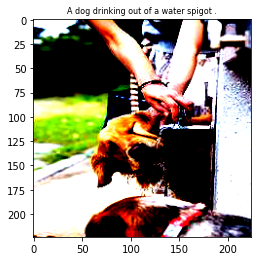

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


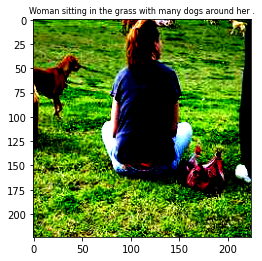

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


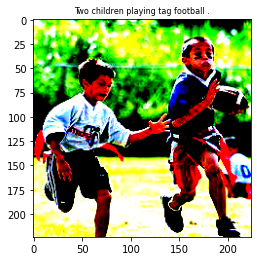

In [108]:
import matplotlib.pyplot as plt

def plotting(loader, args):
    num_imgs = len(loader.dataset)
    for i in range(3):
        img_idx = random.randint(0, num_imgs-1)
        img = loader.dataset[img_idx][0].permute((1, 2, 0))
        with open(args.base_dir+args.part+"/captions/"+args.part+".json", "r") as f:
            dic = json.load(f)
        captions = dic[str(img_idx)+".jpg"]
        plt.imshow(img)
        plt.title(label=captions[random.randint(0, 4)], fontdict={"size": 8})
        plt.show()

with open(base_dir + "vocab.pkl", "rb") as f:
    vocab = pickle.load(f)
    vocab_size = len(vocab)
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                     (0.229, 0.224, 0.225))])
loader = loader = get_loader(base_dir,
                        part, vocab,
                        transform,
                        BATCH_SIZE,
                        shuffle=True,
                        num_workers=NUM_WORKERS)
plotting(loader, config)